In [1]:
import pandas as pd
from pathlib import Path


df = pd.read_parquet(Path("../data/processed/hvbp_2025_clean.parquet"))


domain_cols = ["wt_clinical", "wt_pce", "wt_safety", "wt_efficiency"]

df["tps_calc"] = df[domain_cols].sum(axis=1, skipna=True)  
df["abs_err"]  = (df["tps"] - df["tps_calc"]).abs()

print(f"Max absolute diff = {df['abs_err'].max():.4f}")   
assert df["abs_err"].max() < 0.02, "Mismatch—check the data types or NaNs!"


Max absolute diff = 0.0000


## Linear Regression Baseline: Verifying TPS = Sum of Domain Scores
## This creates a "baseline" that any other model should do better than

In [2]:

X = df[domain_cols].fillna(0)          # simple NaN→0 impute
y = df["tps"]


from sklearn.model_selection import train_test_split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=42)


from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(Xtr, ytr)

print("Train R²:", linreg.score(Xtr, ytr))
print("Test  R²:", linreg.score(Xte, yte))

pd.Series(linreg.coef_, index=domain_cols).to_frame("β coeffs")


Train R²: 1.0
Test  R²: 1.0


,β coeffs
wt_clinical,1.0
wt_pce,1.0
wt_safety,1.0
wt_efficiency,1.0


In [3]:
import joblib, os
os.makedirs("../models", exist_ok=True)
joblib.dump(linreg, "../models/tps_linear.pkl")

['../models/tps_linear.pkl']

# Predicting Top-Quartile Hospital Performance (XGBoost Classifier)
## Model to predict to predict whether a hospital lands in the FY-2025 TPS top-25 %

In [7]:

q75 = df["tps"].quantile(0.75)
y_q4 = (df["tps"] >= q75).astype(int)          # 1 = top 25 %

from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, auc

Xtr, Xte, ytr, yte = train_test_split(X, y_q4, test_size=0.20, stratify=y_q4,
                                      random_state=42)

xgb = XGBClassifier(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        scale_pos_weight = (y_q4==0).sum() / (y_q4==1).sum()  # handles class imbalance
      ).fit(Xtr, ytr)

proba = xgb.predict_proba(Xte)[:,1]
prec, rec, _ = precision_recall_curve(yte, proba)
print("PR-AUC:", auc(rec, prec))
joblib.dump(xgb, "../models/tps_topquartile_xgb.pkl")



PR-AUC: 0.9680116281817412


['../models/tps_topquartile_xgb.pkl']

#### PR-AUC = 0.97 means the XGBoost model is very reliable at identifying which hospitals will be top performers.


## Feature-importance bar plot for the XGB classifier


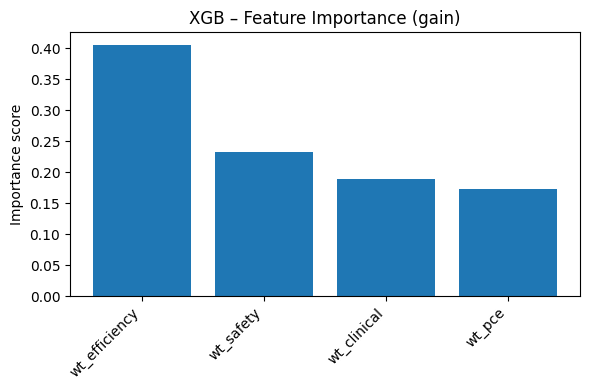

In [8]:

import numpy as np
import matplotlib.pyplot as plt


importances = xgb.feature_importances_        
feat_names  = X.columns                       


order = np.argsort(importances)[::-1]


plt.figure(figsize=(6, 4))
plt.bar(range(len(order)), importances[order], tick_label=feat_names[order])
plt.title("XGB – Feature Importance (gain)")
plt.ylabel("Importance score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


plt.savefig("../figures/xgb_feature_importance.png", dpi=150)
plt.show()


#### Efficiency contributes ~40 % of the model’s predictive gain, confirming the domain’s influence on top-quartile status. Safety is the next strongest drive, when it is present.